# Case 3

In this code we will compare SOLA-DLI with a classic least square method for obtaining a discretized model solution to the problem:
$
\begin{equation}
    G(m) = d
\end{equation}
$

We will use some orthonormal basis functions $\{B_k\}$ to discretize the model. The true model can be written as:
$
\begin{equation}
    \bar{m} = \bar{m}^{\perp} + \bar{m}^{\parallel}
\end{equation}
$
where
$
\begin{equation}
    \bar{m}^{\parallel} = \sum_k p_k B_k 
\end{equation}
$
is the part of the true model that is found in the span of our basis functions $B_k$. The coefficients $p_k$ can be found from:
$
\begin{equation}
    p_k = \int_{[0,1]} B_k(r) m(r) dr
\end{equation}
$
The easy way of solving this probllem is as follows: 
$
\begin{gather}
    d_i = G(m) = G(m^{\perp}) + G(m^{\parallel}) \\
    d_i = \int_{[0, 1]} K_i \left( \sum_k p_k B_k \right) dr + G(m^{\perp}) \\
    d_i - G(m^{\perp}) = \sum_k \left ( \int_{[0, 1]} K_i B_k \right) p_k \\
    \text{Now ignore } G(m^{\perp}) \text{ and let } \Gamma_{ik} = \int_{[0, 1]} K_i B_k dr\\
    \bm{d} = \bm{\Gamma} \bm{p} \\
    \bm{p} = \bm{\Gamma}^{-1} \bm{d}
\end{gather}
$
So basically, we approximate the true relationship $G$ by $\Gamma$, which contains the coefficients of the projections of the sensitivity kernels onto the basis functions $B_k$ and we ignore the part of the model that is not in the span of the basis functions. This leads to a systematic error in the solution that can be removed by using SOLA-DLI instead. To use SOLA-DLI we define a property mapping:
$
\begin{equation}
    p_k = \Tau(m) = \int_{[0, 1]} B_k(r) m(r) dr
\end{equation}
$
and we solve the following problem:
$
\begin{gather}
    \text{Given that} \\
    G(m) = d \\
    \lVert m \rVert _{\mathcal{M}} \leq M \\
    \text{Find} \\
    \Tau(\bar{m}) = \bar{p}_k 
\end{gather}
$

In [135]:
from sola.main_classes import domains
from sola.main_classes import spaces
from sola.aux.normal_data import load_normal_data
from sola.main_classes import functions
from sola.main_classes import mappings
from sola.main_classes.SOLA_DLI import Problem

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import random

# Set global parameters for matplotlib
plt.rcParams.update({'font.size': 15})  # Set default font size
plt.rcParams['axes.linewidth'] = 1.5  # Set the thickness of the axes lines
# Create color Palette
colors = sns.color_palette('YlGnBu', n_colors=100)


First we create a model space (PCb[0, 1])

In [136]:
####################
# Create model space
####################
# Edit region -------------
physical_parameters = ['m']
physical_parameters_symbols = {'m': '$m$'}
# Edit region -------------

no_of_params = len(physical_parameters)
domain = domains.HyperParalelipiped(bounds=[[0, 1]], fineness=1000)
constituent_models_spaces = [spaces.PCb(domain=domain) for _ in physical_parameters]
# Create a dictionary with physical_parameters as keys
models_dict = {param: model_space for param, model_space in zip(physical_parameters, constituent_models_spaces)}
M = spaces.DirectSumSpace(tuple(constituent_models_spaces))

Then the corresponding data space. In this case we have 100 error-free data points. 

In [202]:
###################
# Create Data space
###################
# Edit region -------------
how_many_data = 70
# Edit region -------------

D = spaces.RN(dimension=how_many_data)

The relation between model and data is given by:
$
\begin{equation}
    d_i = \int_{[0, 1]} m(r) K_i(r) dr 
\end{equation}
$
where $K_i(r)$ are some fake sensitvity kernels. 

In [203]:
###########################
# Create model-data mapping
###########################
# Make them into functions via interpolation
sensitivity_dict = {}
for i, param in enumerate(physical_parameters):
    sensitivity_dict[param] = []
    for index in range(how_many_data):
        sensitivity_dict[param].append(functions.NormalModes_1D(domain=domain, order=5, spread=0.02,
                                                    max_freq=30, seed=index + i*how_many_data))

constituent_mappings = [mappings.IntegralMapping(domain=models_dict[param], codomain=D,
                                        kernels=sensitivity_dict[param]) for param in physical_parameters]
mappings_dict = {param: mapping for param, mapping in zip(physical_parameters, constituent_mappings)}
G = mappings.DirectSumMapping(domain=M, codomain=D, mappings=tuple(constituent_mappings))

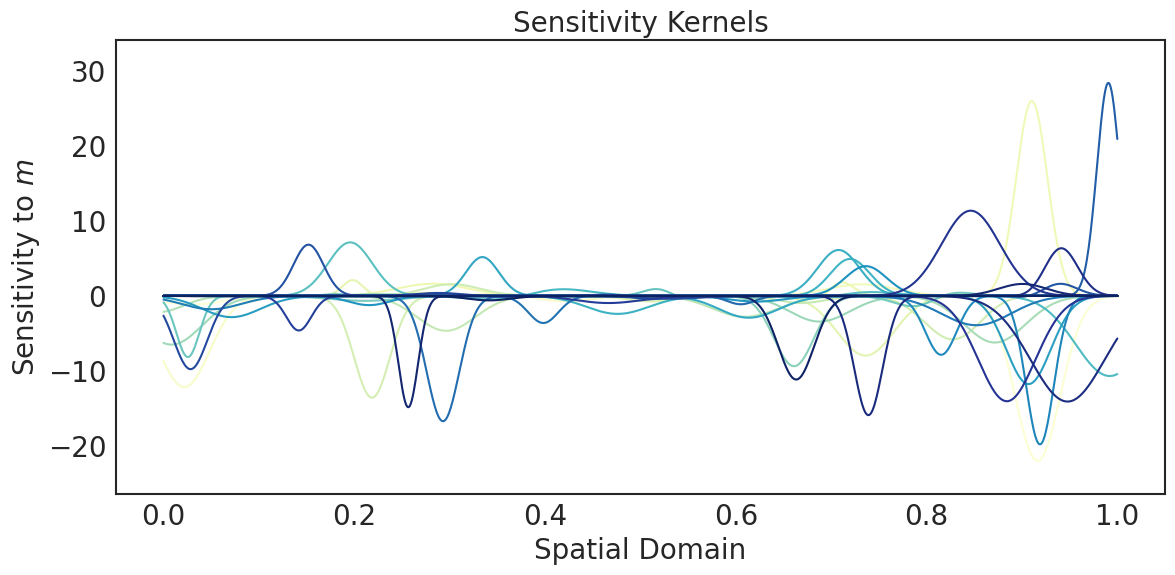

In [204]:
%matplotlib inline
fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12, 6*len(physical_parameters)))

for i, param in enumerate(physical_parameters):
    # Initialize y_min and y_max with extreme values to be updated dynamically
    y_min = float('inf')
    y_max = float('-inf')

    for j, kernel in enumerate(sensitivity_dict[param]):
        y_values = kernel.evaluate(domain.mesh)  # Extract y-values from the kernel data

        # Update y_min and y_max based on current kernel's data
        y_min = min(y_min, np.min(y_values))
        y_max = max(y_max, np.max(y_values))

        axes.plot(domain.mesh, y_values, color=colors[int(100*j/how_many_data)])
    y_min *= 1.2
    y_max *= 1.2
    axes.tick_params(axis='both', which='major', labelsize=15)
    axes.set_ylim([y_min, y_max])
    axes.set_ylabel('Sensitivity to ' + physical_parameters_symbols[param], fontsize=20)

# Adjust fontsize for ticks
axes.set_title('Sensitivity Kernels', fontsize=20)
axes.set_xlabel('Spatial Domain', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig('Case_3_images/kernels_for_fourier.png', bbox_inches='tight', dpi=300)
plt.show()

Now, for SOLA we need to define a property mapping. The key is to use the basis functions as target kernels.

In [205]:
###################################
# Create property mapping and space
###################################
# Edit region -------------
target_types = {'m': functions.Fourier}
orders = np.arange(0,15,1,dtype=int)
how_many_targets = 2*len(orders) - 1
# Edit region -------------
P = spaces.RN(dimension=how_many_targets)
targets_dict = {}
for param, target_type in target_types.items():
    targets_dict[param] = []
    for i in range(how_many_targets):
        if target_type == functions.Fourier: # MODIFY HERE THE SPECIAL TARGET AS WELL!!!!
            if i == 0:
                target = target_type(domain=domain,type='cos', order=0)
            elif (i % 2 == 1):
                target = target_type(domain=domain,type='sin', order=int(i/2)+1)
            else:
                target = target_type(domain=domain,type='cos', order=i/2)
            targets_dict[param].append(target)
        else:
            targets_dict[param].append(target_type(domain=domain))
constituent_mappings = [mappings.IntegralMapping(domain=models_dict[param], codomain=P,
                                        kernels=targets_dict[param]) for param in physical_parameters]
T = mappings.DirectSumMapping(domain=M, codomain=P, mappings=tuple(constituent_mappings))

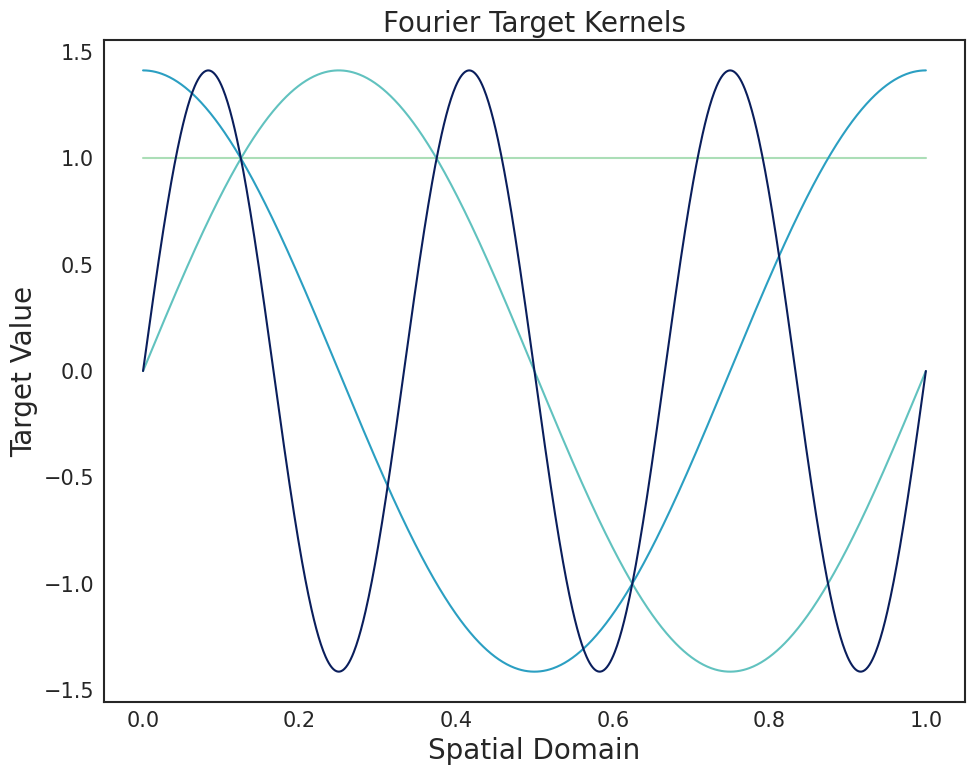

In [206]:
%matplotlib inline
plt.figure('Targets', figsize=(10,8))
for index in [0,1,2,5]:
    plt.plot(domain.mesh, targets_dict[param][index].evaluate(domain.mesh),
            color=colors[int(70*index/5 + 30 - 1)])
plt.title('Fourier Target Kernels', fontsize=20)
plt.xlabel('Spatial Domain', fontsize=20)
plt.ylabel('Target Value', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('Case_3_images/Fourier_targets.png', bbox_inches='tight', dpi=300)
plt.show()

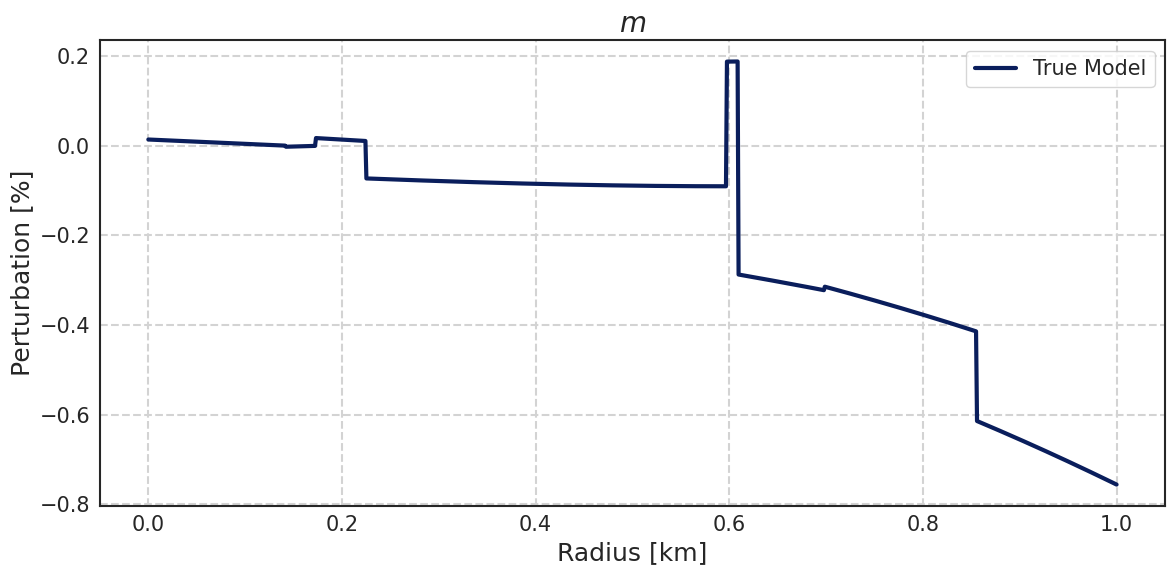

In [207]:
#################################
# Create fake true model and data
#################################
true_model = M.random_member(args_list=[(4,)])
data = G.map(true_model)

fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12,6*len(physical_parameters)))
for i, (submodel, physical_parameter) in enumerate(zip(true_model, physical_parameters)):
    axes.plot(domain.mesh, submodel.evaluate(domain.mesh),
            label='True Model', color=colors[99], linewidth=3)
    axes.set_title(physical_parameters_symbols[physical_parameter], fontsize=20)
    axes.set_xlabel('Radius [km]', fontsize=18)
    axes.set_ylabel('Perturbation [%]', fontsize=18)
    axes.tick_params(axis='both', which='major', labelsize=15)
    axes.legend(fontsize=15)
    axes.grid(True, linestyle='--', linewidth=1.5, color='lightgray')  # Add gridlines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('Case_3_images/truth.png', dpi=300, bbox_inches='tight')  # Save figure
plt.show()

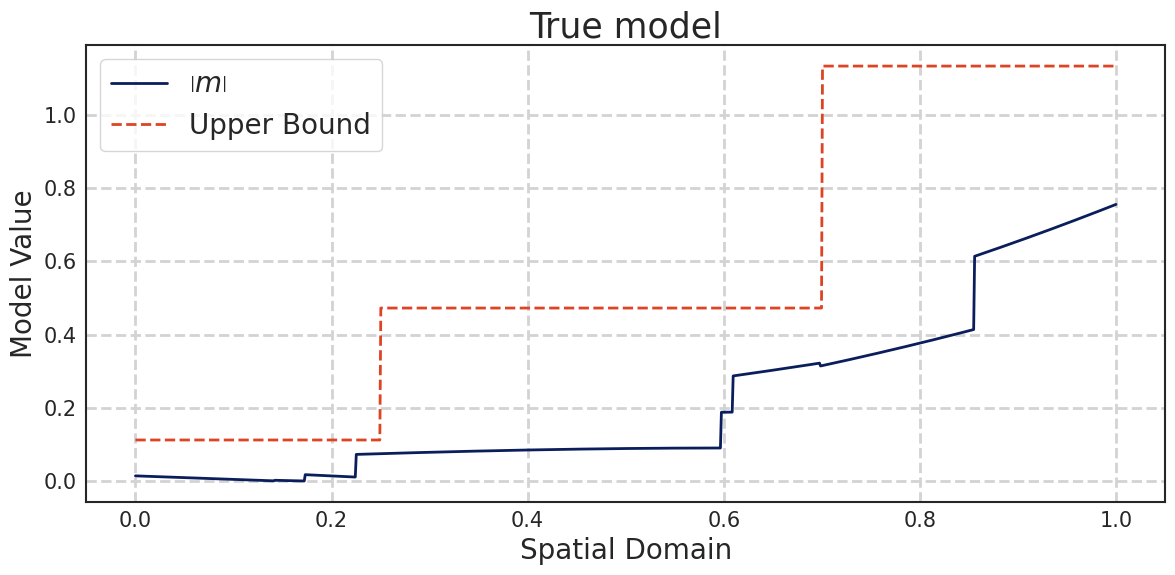

In [208]:
####################
# Compute norm bound
####################
# Edit region -------------
# Places where the true model will be evaluated
intervals = np.array([0, 0.25, 0.7, domain.bounds[0][1]])
# Edit region -------------
upper_bounds = []
for model in true_model:
    values = np.abs(model.evaluate(intervals[1:]))*1.5
    upper_bound = functions.Piecewise_1D(domain=model.domain,
                               intervals=intervals,
                               values=values)
    upper_bounds.append(upper_bound)
norm_bound = M.norm(tuple(upper_bounds))

fig, axes = plt.subplots(len(physical_parameters), 1, figsize=(12,6*len(physical_parameters)))

for i, (upperbound, submodel, physical_parameter) in enumerate(zip(upper_bounds, true_model, physical_parameters)):
    axes.plot(domain.mesh, np.abs(submodel.evaluate(domain.mesh)),
             label=r'$\left| m \right|$', color=colors[99], linewidth=2)
    axes.plot(domain.mesh, upperbound.evaluate(domain.mesh),
             label='Upper Bound', color='#dd4423', linestyle='--', linewidth=2)
    # Set title and labels
    axes.set_ylabel('Model Value', fontsize=20)
    # Set tick parameters
    axes.tick_params(axis='both', which='major', labelsize=15)
    # Add legend
    axes.legend(fontsize=15)
    axes.grid(True, linestyle='--', linewidth=2, color='lightgray')  # Add gridlines
    axes.legend(fontsize=20)
plt.title('True model', fontsize=25)
plt.xlabel('Spatial Domain', fontsize=20)
plt.tight_layout()
plt.savefig('Case_3_images/bound_fourier.png', bbox_inches='tight')
plt.show()

We form the SOLA-DLI problem

In [209]:
# Instantiate the SOLA problem
problem = Problem(M=M, D=D, P=P, G=G, T=T, norm_bound=norm_bound, data=data)

And solve it

In [210]:
# Solve the SOLA problem
problem.solve()

In [211]:
# Compute True property
true_property = T.map(true_model)

In [212]:
# Compute least square inversion solution (Fourier Coefficients)
inversion_property_solution = np.linalg.lstsq(problem.Gamma.matrix.T, data)[0]

/tmp/ipykernel_11192/3651275910.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  inversion_property_solution = np.linalg.lstsq(problem.Gamma.matrix.T, data)[0]


In [213]:
# Compute the various solutions to be plotted
upper_bounds = [item for sublist in problem.solution['upper bound'] for item in sublist]
lower_bounds = [item for sublist in problem.solution['lower bound'] for item in sublist]

least_norm_property_solution = problem.T_adjoint.map(problem.least_norm_property)[0]
LSQR_inverse_solution = problem.T_adjoint.map(inversion_property_solution) # This is just the solution to the inversion problem
projected_sol = problem.T_adjoint.map(true_property) # This is what we get when we project the true model onto the span of the basis functions
my_sol_upper = problem.T_adjoint.map(np.array(upper_bounds).reshape(len(upper_bounds), 1))[0]
my_sol_lower = problem.T_adjoint.map(np.array(lower_bounds).reshape(len(lower_bounds), 1))[0]

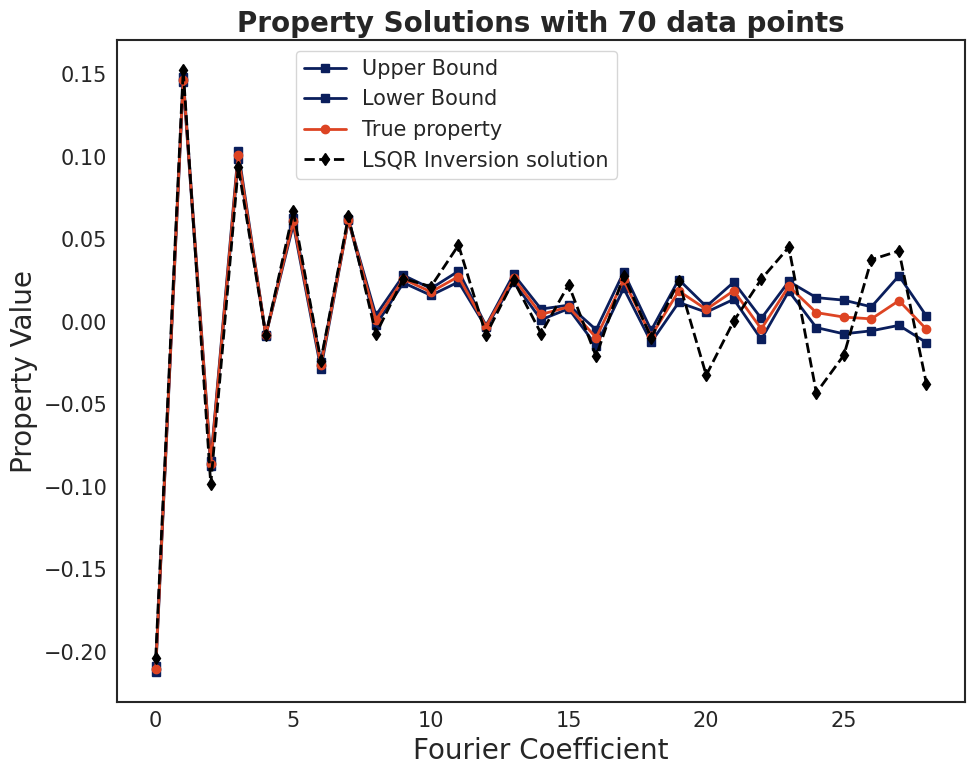

In [214]:
###############
# Plot solution
###############
# Find limits for y axis
y_max = np.max(true_property)*1.5
y_min = np.min(true_property)*1.5
enquiry_points = np.arange(0, how_many_targets)
# Plot the Solution section
plt.figure('Solution', figsize=(10, 8))
sns.set_style(style='white')  # Set seaborn style
plt.title('Property Solutions with ' + str(how_many_data) + ' data points',
          fontsize=20, fontweight='bold')  # Increase font size and add bold
plt.plot(enquiry_points, problem.solution['upper bound'], color=colors[99],
         linewidth=2, label='Upper Bound', marker='s')  # Increase line width
plt.plot(enquiry_points, problem.solution['lower bound'], color=colors[99],
         linewidth=2, label='Lower Bound', marker='s')  # Increase line width and use dashed line
plt.plot(enquiry_points, true_property, color='#dd4423',
         linewidth=2, label='True property', marker='o')
plt.plot(enquiry_points, inversion_property_solution, color='black', marker='d',
            label='LSQR Inversion solution', linestyle='dashed', linewidth=2)
# plt.ylim([y_min, y_max])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='upper center', bbox_to_anchor=(0.4, 1))

plt.xlabel('Fourier Coefficient', fontsize=20)  # Add X-axis label with fontsize
plt.ylabel('Property Value', fontsize=20)  # Add Y-axis label with fontsize
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('Case_3_images/new_theory_solution_' + str(how_many_data), dpi=300, bbox_inches='tight')  # Increase resolution for high-quality output
plt.show()

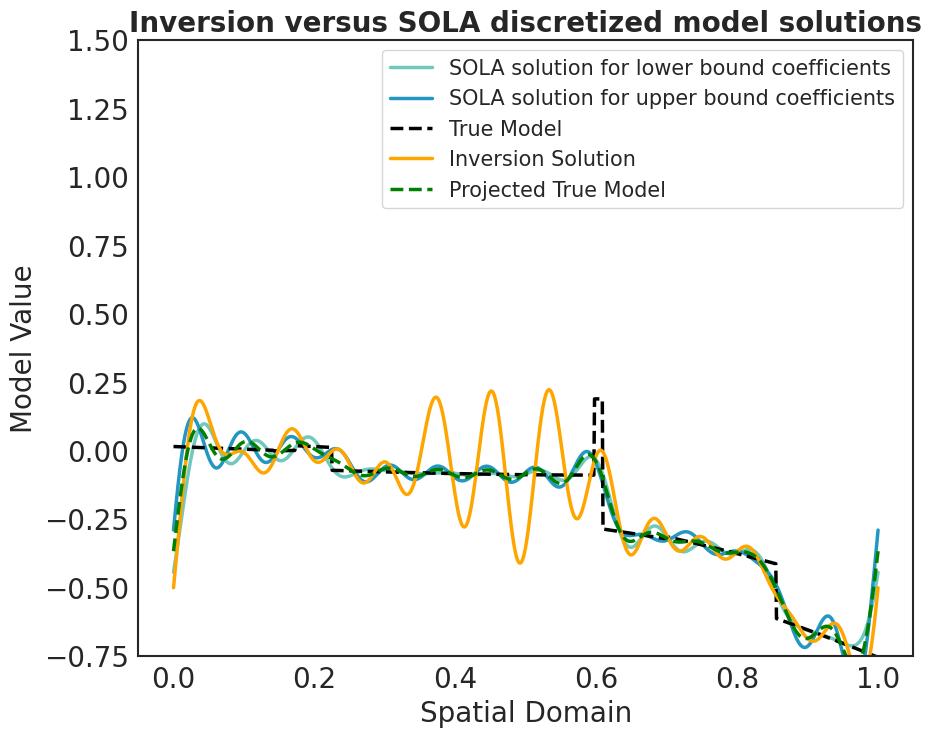

In [215]:
plt.figure('new_theory', figsize=(10,8))

# Plot the upper and lower bound solutions
plt.plot(domain.mesh, my_sol_lower.evaluate(domain.mesh),
        color=colors[40], linewidth=2.5,
        label='SOLA solution for lower bound coefficients')

plt.plot(domain.mesh, my_sol_upper.evaluate(domain.mesh),
        color=colors[60], linewidth=2.5,
        label='SOLA solution for upper bound coefficients')

plt.plot(domain.mesh, true_model[0].evaluate(domain.mesh),
        color='black', label='True Model', linestyle='dashed',
        linewidth=2.5)
plt.plot(domain.mesh, LSQR_inverse_solution[0].evaluate(domain.mesh),
        color='orange', label='Inversion Solution', linewidth=2.5)
plt.plot(domain.mesh, projected_sol[0].evaluate(domain.mesh),
        color='green', label='Projected True Model', linestyle='dashed',
        linewidth=2.5)
plt.ylim([-0.75,1.5])
plt.title('Inversion versus SOLA discretized model solutions', fontsize=20,
        fontweight='bold')
plt.legend(fontsize=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Spatial Domain', fontsize=20)
plt.ylabel('Model Value', fontsize=20)
plt.savefig('Case_3_images/discretized_model_' + str(how_many_data) + '.png', dpi=300, bbox_inches='tight')
plt.show()

We will now compute the LSQR inversion solution with corrected data. 

In [216]:
# Find corrected data)
corrected_data = G.map(projected_sol)
# Find LSQR inversion solution with the corrected data
corrected_inversion_property_solution = np.linalg.lstsq(problem.Gamma.matrix.T, corrected_data)[0]

/tmp/ipykernel_11192/2490423534.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  corrected_inversion_property_solution = np.linalg.lstsq(problem.Gamma.matrix.T, corrected_data)[0]


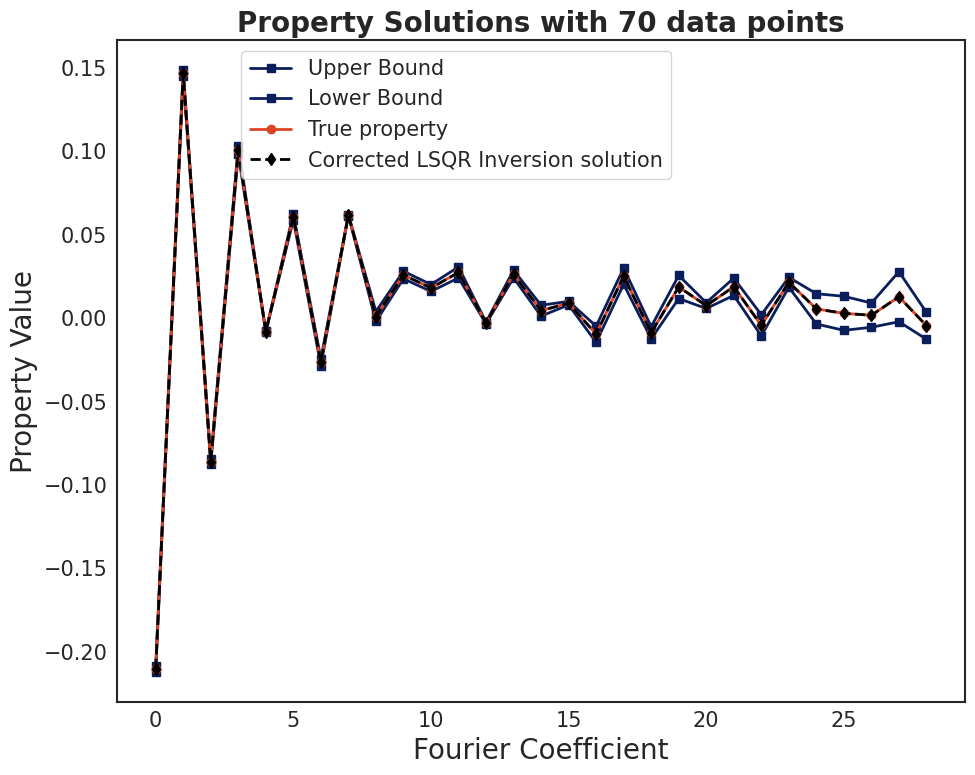

In [217]:
###############
# Plot solution
###############
# Find limits for y axis
y_max = np.max(true_property)*1.5
y_min = np.min(true_property)*1.5
enquiry_points = np.arange(0, how_many_targets)
# Plot the Solution section
plt.figure('Solution', figsize=(10, 8))
sns.set_style(style='white')  # Set seaborn style
plt.title('Property Solutions with ' + str(how_many_data) + ' data points',
          fontsize=20, fontweight='bold')  # Increase font size and add bold
plt.plot(enquiry_points, problem.solution['upper bound'], color=colors[99],
         linewidth=2, label='Upper Bound', marker='s')  # Increase line width
plt.plot(enquiry_points, problem.solution['lower bound'], color=colors[99],
         linewidth=2, label='Lower Bound', marker='s')  # Increase line width and use dashed line
plt.plot(enquiry_points, true_property, color='#dd4423',
         linewidth=2, label='True property', marker='o')
plt.plot(enquiry_points, corrected_inversion_property_solution, color='black', marker='d',
            label='Corrected LSQR Inversion solution', linestyle='dashed', linewidth=2)
# plt.ylim([y_min, y_max])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15, loc='upper center', bbox_to_anchor=(0.4, 1))

plt.xlabel('Fourier Coefficient', fontsize=20)  # Add X-axis label with fontsize
plt.ylabel('Property Value', fontsize=20)  # Add Y-axis label with fontsize
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('Case_3_images/corrected_new_theory_solution_' + str(how_many_data), dpi=300, bbox_inches='tight')  # Increase resolution for high-quality output
plt.show()